# Benchmarking simple CDR3 Beta Levenshtein distance

## Setup

In [1]:
import os
from pathlib import Path
import sys

if "__project_dir__" not in globals():
    __project_dir__ = Path.cwd().parent.resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [2]:
from itertools import combinations
import json
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, notna
from pathlib import Path
from rapidfuzz.process import cdist
from rapidfuzz.distance import Levenshtein
import seaborn
import torch
from tqdm import tqdm

seaborn.set_theme()
seaborn.set_style("white")

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

### Create benchmarking directory

In [4]:
BENCHMARK_DIR = Path(f"benchmarks_beta/CDR3 Levenshtein")
if not BENCHMARK_DIR.is_dir():
    BENCHMARK_DIR.mkdir()

### Create cache directory

In [5]:
CACHE_DIR = BENCHMARK_DIR / ".cache"
if not CACHE_DIR.is_dir():
    CACHE_DIR.mkdir()

### Load data

In [6]:
back_df = pd.read_csv(
    "/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/tanno/test.csv"
)
ep_df = pd.read_csv(
    "/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/vdjdb/evaluation_beta.csv"
)

back_df = back_df[["CDR3B"]]
ep_df = ep_df[["CDR3B", "Epitope"]]

In [7]:
epitope_cat_codes = torch.tensor(ep_df["Epitope"].astype("category").cat.codes).to(
    device
)

## Calculate alignment and uniformity

In [8]:
NUM_EPITOPES = ep_df["Epitope"].nunique()
EPGRP_SIZE = ep_df.groupby("Epitope").size().iloc[0]

In [9]:
if (CACHE_DIR / "ep_cdist.pt").is_file():
    ep_cdist = torch.load(CACHE_DIR / "ep_cdist.pt").to(device)
else:
    ep_cdist = cdist(ep_df["CDR3B"], ep_df["CDR3B"], scorer=Levenshtein.distance)
    ep_cdist = torch.tensor(ep_cdist, dtype=torch.float32).to(device)
    torch.save(ep_cdist.cpu(), CACHE_DIR / "ep_cdist.pt")

In [10]:
if (CACHE_DIR / "back_cdist.pt").is_file():
    back_cdist = torch.load(CACHE_DIR / "back_cdist.pt").to(device)
else:
    back_cdist = cdist(
        back_df["CDR3B"].iloc[:10000],
        back_df["CDR3B"].iloc[:10000],
        scorer=Levenshtein.distance,
    )
    back_cdist = torch.tensor(back_cdist, dtype=torch.float32).to(device)
    torch.save(back_cdist.cpu(), CACHE_DIR / "back_cdist.pt")

In [11]:
ep_alignments = []

for i in range(NUM_EPITOPES):
    start_idx = i * EPGRP_SIZE
    end_idx = (i + 1) * EPGRP_SIZE
    ep_view = ep_cdist[start_idx:end_idx, start_idx:end_idx]

    ep_alignments.append((ep_view.sum() / (EPGRP_SIZE * (EPGRP_SIZE - 1))).item())

alignment = torch.tensor(ep_alignments).mean().item()

In [12]:
back_cdist_neg_exp = back_cdist.mul(-1).exp()
uniformity_exp = back_cdist_neg_exp.sum() / (10000 * 9999)
uniformity = uniformity_exp.log().item()

## k-NN evaluation

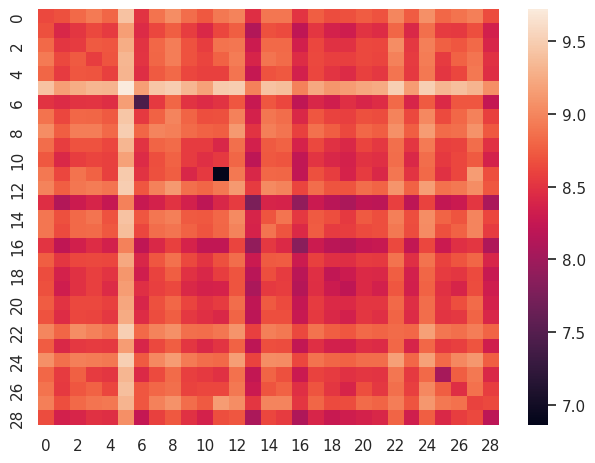

In [13]:
avg_dist_in_group = torch.nn.functional.avg_pool2d(
    ep_cdist.unsqueeze(0), EPGRP_SIZE
).squeeze(0)
scaling_factor = (
    torch.ones(NUM_EPITOPES, NUM_EPITOPES)
    .fill_diagonal_(EPGRP_SIZE / (EPGRP_SIZE - 1))
    .to(device)
)
avg_dist_in_group *= scaling_factor

c_dist_map = seaborn.heatmap(avg_dist_in_group.cpu().detach().numpy())
plt.tight_layout()
plt.savefig(BENCHMARK_DIR / "cdists.png")
plt.show()

In [14]:
ep_cdist.device

device(type='cuda', index=0)

In [15]:
ep_cdist.fill_diagonal_(torch.inf)

tensor([[inf,  7.,  8.,  ...,  8.,  6., 10.],
        [ 7., inf,  6.,  ...,  5.,  5.,  9.],
        [ 8.,  6., inf,  ...,  9.,  9., 11.],
        ...,
        [ 8.,  5.,  9.,  ..., inf,  5.,  6.],
        [ 6.,  5.,  9.,  ...,  5., inf,  9.],
        [10.,  9., 11.,  ...,  6.,  9., inf]], device='cuda:0')

In [16]:
knn_scores = dict()

for k in (5, 10, 50, 100):
    scores = []
    ep_size = len(ep_df)

    for tcr_index in tqdm(range(ep_size)):
        # Get correct epitope label
        expected = epitope_cat_codes[tcr_index]

        # Get list of distances for that TCR
        dists = ep_cdist[tcr_index]

        # Get indices of nearest neighbours
        _, idcs = torch.topk(dists, k=k, largest=False)

        # Get epitopes of nearest neighbours
        knn_cat_codes = epitope_cat_codes[idcs]

        # Predict epitope
        pred, _ = torch.mode(knn_cat_codes)

        # Record score
        scores.append(expected.item() == pred.item())

    score = torch.tensor(scores, dtype=torch.float32).mean().item()

    print(f"{k}-NN score: {score}")

    knn_scores[k] = score

100%|██████████| 2900/2900 [00:00<00:00, 6672.11it/s]


5-NN score: 0.17241379618644714


100%|██████████| 2900/2900 [00:00<00:00, 7446.32it/s]


10-NN score: 0.17275862395763397


100%|██████████| 2900/2900 [00:00<00:00, 7936.51it/s]


50-NN score: 0.15344826877117157


100%|██████████| 2900/2900 [00:00<00:00, 8287.12it/s]

100-NN score: 0.14379310607910156


## Write out evaluation metrics to json

In [17]:
metrics_dict = {
    "model_name": "CDR3 Levenshtein",
    "alignment": alignment,
    "uniformity": uniformity,
    "knn_scores": knn_scores,
}

In [18]:
with open(BENCHMARK_DIR / "metrics.json", "w") as f:
    json.dump(metrics_dict, f, indent=4)